# Install some requirement packages

In [ ]:
!pip install 'networkx>2.7'
!pip install 'scipy>=1.8'
!pip install scikit-learn==1.2.1

# Main code

In [ ]:
import warnings
warnings.filterwarnings('ignore')
from matplotlib.pyplot import figure
import networkx.algorithms.community as nxcom
from sklearn.metrics import silhouette_samples, silhouette_score
import pandas as pd
import csv
import pickle
import numpy as np
import ast
from numpy.linalg import matrix_power
import itertools
import math
import random
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import scipy
from scipy.sparse import csc_matrix
from scipy.sparse.linalg import gmres
from scipy.linalg import schur, eigvals
import math
import itertools
from numpy import linalg as LA
import seaborn as sns
from sklearn.cluster import KMeans
import numpy as np
from numpy import linalg as LA
import networkx as nx
import networkx as nx
from numpy.linalg import matrix_power
%matplotlib inline
import random
# from dscores import *
# from directed_louvain import *
import random
import networkx.algorithms.community as nx_comm
import time
from numpy.linalg import inv, norm, pinv
import pandas as pd
import csv
from scipy.linalg import issymmetric

In [ ]:
from sklearn.cluster import KMeans
import numpy as np
from numpy import linalg as LA
import networkx as nx
import networkx as nx
from numpy.linalg import matrix_power
def R_matrix_Dscore(matrix,T_n):
    shape_matrix = matrix.shape
    res = matrix
    n = shape_matrix[0]
    result = np.array([[res[i,k+1]/res[i,0] if abs(res[i,k+1]/res[i,0]) <= T_n else np.sign(res[i,k+1]/res[i,0])*T_n for k in range(shape_matrix[1]-1)] for i in range(n)])
    return result
def R_matrix_Dscore_q(matrix,T_n):
    shape_matrix = matrix.shape
    res = matrix
    n = shape_matrix[0]
    result = np.array([[res[i,k]/LA.norm(res[i,:]) if abs(res[i,k]/LA.norm(res[i,:])) <= T_n else np.sign(res[i,k]/LA.norm(res[i,:]))*T_n for k in range(shape_matrix[1])] for i in range(n)])
    return result
def DScore(adj_matrix, nber_comm): # numy array het
    K = nber_comm
    A = adj_matrix
    n = A.shape[0]
    U, s, Vh = LA.svd(A) # U la left, V (not Vh) la right singular vector
    V = Vh.T
    U_rutgon = U[:,:K]
    V_rutgon = V[:,:K]
    s_rutgon = s[:K]
    T_n = np.log(n)
    R_U = R_matrix_Dscore(U_rutgon,T_n)
    R_V = R_matrix_Dscore(V_rutgon,T_n)
    R = np.concatenate((R_U, R_V), axis=1)
    kmeans = KMeans(n_clusters=K, random_state=0, n_init="auto").fit(R)
    lst_label_kmeans = kmeans.labels_.tolist()
    bp_kmeans = []
    for j in range(K):
        indices = [i for i, x in enumerate(lst_label_kmeans) if x == j]
        bp_kmeans.append(indices)
    return bp_kmeans
def DScore_q(adj_matrix, nber_comm): # numy array het
    K = nber_comm
    A = adj_matrix
    n = A.shape[0]
    U, s, Vh = LA.svd(A) # U la left, V (not Vh) la right singular vector
    V = Vh.T
    U_rutgon = U[:,:(K)]
    V_rutgon = V[:,:(K)]
    s_rutgon = s[:(K)]
    T_n = np.log(n)
    R_U = R_matrix_Dscore_q(U_rutgon,T_n)
    R_V = R_matrix_Dscore_q(V_rutgon,T_n)
    R = np.concatenate((R_U, R_V), axis=1)
    kmeans = KMeans(n_clusters=K, random_state=0, n_init="auto").fit(R)
    lst_label_kmeans = kmeans.labels_.tolist()
    bp_kmeans = []
    for j in range(K):
        indices = [i for i, x in enumerate(lst_label_kmeans) if x == j]
        bp_kmeans.append(indices)
    return bp_kmeans
def improved_DScore(adj_matrix, nber_comm):
    K = nber_comm
    A = adj_matrix
    n = A.shape[0]
    U, s, Vh = LA.svd(A)
    V = Vh.T
    U_rutgon = U[:,:(K)]
    V_rutgon = V[:,:(K)]
    s_rutgon = s[:(K)]
    AA_T = np.dot(A,A.T)
    A_TA = np.dot(A.T,A)
    G_temp1 = nx.from_numpy_array(AA_T, create_using = nx.DiGraph())
    lst_components = [list(c) for c in sorted(nx.strongly_connected_components(G_temp1), key=len, reverse=True)]
    lst_len_components = [len(i) for i in lst_components]
    S1 = set(lst_components[lst_len_components.index(max(lst_len_components))])
    G_temp2 = nx.from_numpy_array(A_TA, create_using = nx.DiGraph())
    lst_components = [list(c) for c in sorted(nx.strongly_connected_components(G_temp2), key=len, reverse=True)]
    lst_len_components = [len(i) for i in lst_components]
    S2 = set(lst_components[lst_len_components.index(max(lst_len_components))])
    core_graph = sorted(list(S1.intersection(S2)))
    U_rutgon2 = U_rutgon[core_graph,:]
    V_rutgon2 = V_rutgon[core_graph,:]
    T_n = np.log(len(core_graph))
    R_U = R_matrix_Dscore(U_rutgon2,T_n)
    R_V = R_matrix_Dscore(V_rutgon2,T_n)
    R = np.concatenate((R_U, R_V), axis=1)
    kmeans = KMeans(n_clusters=K, random_state=0, n_init="auto").fit(R)
    lst_label_kmeans = kmeans.labels_.tolist()
    bp_kmeans_core_graph = []
    for j in range(K):
        indices = [i for i, x in enumerate(lst_label_kmeans) if x == j]
        bp_kmeans_core_graph.append(indices)
    dct_label_core_graph = {core_graph[i]:lst_label_kmeans[i] for i in range(len(core_graph))}
    out_core_nodes = set([i for i in range(n)]) - set(core_graph)
    lst_node_center = kmeans.cluster_centers_.tolist()
    dct_label_out_core_graph = {}
    for nod in out_core_nodes:
        lst_check = [sum([A[nod,i] + A[i,nod] for i in bp_kmeans_core_graph[j]]) for j in range(len(bp_kmeans_core_graph))]
        idx = lst_check.index(max(lst_check))
        bp_kmeans_core_graph[idx].append(nod)
    return bp_kmeans_core_graph
def improved_DScore_q(adj_matrix, nber_comm):
    K = nber_comm
    A = adj_matrix
    n = A.shape[0]
    U, s, Vh = LA.svd(A)
    V = Vh.T
    U_rutgon = U[:,:(K)]
    V_rutgon = V[:,:(K)]
    s_rutgon = s[:(K)]
    AA_T = np.dot(A,A.T)
    A_TA = np.dot(A.T,A)
    G_temp1 = nx.from_numpy_array(AA_T, create_using = nx.DiGraph())
    lst_components = [list(c) for c in sorted(nx.strongly_connected_components(G_temp1), key=len, reverse=True)]
    lst_len_components = [len(i) for i in lst_components]
    S1 = set(lst_components[lst_len_components.index(max(lst_len_components))])
    G_temp2 = nx.from_numpy_array(A_TA, create_using = nx.DiGraph())
    lst_components = [list(c) for c in sorted(nx.strongly_connected_components(G_temp2), key=len, reverse=True)]
    lst_len_components = [len(i) for i in lst_components]
    S2 = set(lst_components[lst_len_components.index(max(lst_len_components))])
    core_graph = sorted(list(S1.intersection(S2)))
    U_rutgon2 = U_rutgon[core_graph,:]
    V_rutgon2 = V_rutgon[core_graph,:]
    T_n = np.log(len(core_graph))
    R_U = R_matrix_Dscore_q(U_rutgon2,T_n)
    R_V = R_matrix_Dscore_q(V_rutgon2,T_n)
    R = np.concatenate((R_U, R_V), axis=1)
    kmeans = KMeans(n_clusters=K, random_state=0, n_init="auto").fit(R)
    lst_label_kmeans = kmeans.labels_.tolist()
    bp_kmeans_core_graph = []
    for j in range(K):
        indices = [i for i, x in enumerate(lst_label_kmeans) if x == j]
        bp_kmeans_core_graph.append(indices)
    dct_label_core_graph = {core_graph[i]:lst_label_kmeans[i] for i in range(len(core_graph))}
    out_core_nodes = set([i for i in range(n)]) - set(core_graph)
    lst_node_center = kmeans.cluster_centers_.tolist()
    dct_label_out_core_graph = {}
    for nod in out_core_nodes:
        lst_check = [sum([A[nod,i] + A[i,nod] for i in bp_kmeans_core_graph[j]]) for j in range(len(bp_kmeans_core_graph))]
        idx = lst_check.index(max(lst_check))
        bp_kmeans_core_graph[idx].append(nod)
    return bp_kmeans_core_graph
def oPCA(adj_matrix, nber_comm):
    K = nber_comm
    A = adj_matrix
    n = A.shape[0]
    U, s, Vh = LA.svd(A) # U la left, V (not Vh) la right singular vector
    V = Vh.T
    U_rutgon = U[:,:K]
    V_rutgon = V[:,:K]
    s_rutgon = s[:K]
    # print("U_rutgon:", U_rutgon.shape, U_rutgon)
    # print("V_rutgon",V_rutgon.shape,  V_rutgon)
    R = np.concatenate((U_rutgon, V_rutgon), axis=1)
    kmeans = KMeans(n_clusters=K, random_state=0, n_init="auto").fit(R)
    lst_label_kmeans = kmeans.labels_.tolist()
    bp_kmeans = []
    for j in range(K):
        indices = [i for i, x in enumerate(lst_label_kmeans) if x == j]
        bp_kmeans.append(indices)
    return bp_kmeans
def preprocess_A_to_L(A):
    total_degree = np.sum(A)
    n = A.shape[0]
    tau = total_degree/n
    O_Vector = [1/np.sqrt(tau + np.sum(A[i,:])) for i in range(n)]
    O_tau = np.diag(O_Vector)
    P_vector = [1/np.sqrt(tau + np.sum(A[:,i])) for i in range(n)]
    P_tau = np.diag(P_vector)
    temp_O = O_tau
    temp_P = P_tau
    return np.dot(np.dot(temp_O,A),temp_P)
def rDScore_q(adj_matrix, nber_comm):
    regular_L = preprocess_A_to_L(adj_matrix)
    return DScore_q(regular_L, nber_comm)
def rDScore(adj_matrix, nber_comm):
    regular_L = preprocess_A_to_L(adj_matrix)
    return DScore(regular_L, nber_comm)
def rPCA(adj_matrix, nber_comm):
    regular_L = preprocess_A_to_L(adj_matrix)
    return oPCA(regular_L, nber_comm)
def r_improved_DScore(adj_matrix, nber_comm):
    regular_L = preprocess_A_to_L(adj_matrix)
    return improved_DScore(regular_L, nber_comm)
def r_improved_DScore_q(adj_matrix, nber_comm):
    regular_L = preprocess_A_to_L(adj_matrix)
    return improved_DScore_q(regular_L, nber_comm)

In [ ]:
# !pip install git+https://github.com/Nathaniel-Rodriguez/graphgen.git

## Create random partition graph

In [ ]:
def generate_community_list(N, C):
	return list(np.random.multinomial(N, [1/C]*C, size=1)[0])
def generate_rand_graph(num_of_vertices, vl):
    num_of_communities = math.ceil(num_of_vertices**vl)
    while True:
        G = nx.generators.community.random_partition_graph(
            generate_community_list(num_of_vertices,num_of_communities)
            , 0.5,0.005, directed = True)
        #print("here")
        if nx.is_strongly_connected(G):
            break

    N = G.number_of_nodes()

    for x in range(N):
        G.add_edge(x, x)
    
    return G
def generate_rand_graph_gaussian(N, mean, sh, p_in, p_out):
    # data_test_record.append('Gaussian random partition generator')
    # lst_param = [N, mean, sh, p_in, p_out]
    # str1 = '-'.join(str(e) for e in lst_param)
    # data_test_record.append(str1)
    while True:
        G = nx.generators.community.gaussian_random_partition_graph(N,mean,sh, p_in,p_out, directed = True)
        if nx.is_strongly_connected(G):
            break

    N = G.number_of_nodes()

    for x in range(N):
        G.add_edge(x, x)
    return G
def generate_rand_graph_partition_l(number_comm, size_each_comm, p_in, p_out):
    # data_test_record.append('Planted l-partition model')
    # lst_param = [number_comm, size_each_comm, p_in, p_out]
    # str1 = '-'.join(str(e) for e in lst_param)
    # data_test_record.append(str1)
    while True:
        G = nx.generators.community.planted_partition_graph(number_comm, size_each_comm
                                                                   , p_in, p_out, directed = True)
        if nx.is_strongly_connected(G):
            break

    N = G.number_of_nodes()

    for x in range(N):
        G.add_edge(x, x)
    return G

In [ ]:
def compute_modularity_general(bp,G):
    # nodes = G.number_of_nodes()
    # all_links = G.number_of_edges()
    # delta_matrix = np.identity(nodes)
    # for C in bp:
    #     aa = list(itertools.combinations(C,2))
    #     for j in aa:
    #         delta_matrix[j[0],j[1]] = 1
    #         delta_matrix[j[1],j[0]] = 1
    # modularity_matrix = np.array(nx.directed_modularity_matrix(G))
    # res = modularity_matrix * delta_matrix # day la nhan tung phan tu
    # q = np.sum(res)/(all_links)
    # return q
    return nx_comm.modularity(G, bp)

# Algorithm 1: WalkTrap Directed (proposed)

In [ ]:
def count_faster_hCj(pii, C, ps_inv_Laplacian,j):
    temp1 = ps_inv_Laplacian[j,j]/pii[j]
    temp2 = ps_inv_Laplacian[:,j][C]
    temp3 = pii[C].tolist()
    temp4 = np.array([math.sqrt(1/t) for t in temp3]).reshape(1,len(C))
    temp2 = temp2.reshape(len(C),1)
    temp5 = np.dot(temp4,temp2)
    #print("temp5:",temp5,"shape of temp2:",temp2.shape,"temp4:",temp4.shape)
    sum1 = temp1 - temp5*1/(len(C)*math.sqrt(pii[j]))
    return float(sum1)

def community_to_adj(pii, C, ps_inv_Laplacian):
    if len(C) > 0:
        n = ps_inv_Laplacian.shape[0]
        res = np.array([count_faster_hCj(pii, C, ps_inv_Laplacian,j) for j in range(n)])
        #print("res.shape:",res.shape)
        return res

def string_list_to_lists(s):
	return (ast.literal_eval(s[:s.index("]",2)+1]),
		ast.literal_eval(s[s.index("]")+1:]))

# Sort communities in ascending order
def sort_communities(C1, C2):
	return sorted(min(C1, C2) + max(C1, C2))

# Sort communities for query
def sort_communities_str(C1, C2):
	return (str(min(C1, C2)) + str(max(C1, C2)))

# Sort community for query
def sort_community(C1):
	return (str(sorted(C1)))


def checking_graph(G1):
    if nx.is_strongly_connected(G1):
        node_1 = list(G1.nodes())[0]
        G1.add_edge(node_1, node_1)
        Adj_matrix_np = nx.to_numpy_array(G1)
        Dout_vector = np.sum(Adj_matrix_np,axis=1).reshape(Adj_matrix_np.shape[0]).tolist()
        Dout_matrix = np.diag(Dout_vector)
        Dout_inverse_matrix = np.diag([1/i for i in Dout_vector])
        P_matrix = np.dot(Dout_inverse_matrix,Adj_matrix_np)
        #print("checking xong nhes")
        return P_matrix, G1
    else:
        print("graph is not strongly connected\n------------------")
        G1 = make_strongly_connected_adj2(G1)
        # G1 = make_strongly_connected(G1)
        node_1 = list(G1.nodes())[0]
        G1.add_edge(node_1, node_1)
        Adj_matrix_np = nx.to_numpy_array(G1)
        Dout_vector = np.sum(Adj_matrix_np,axis=1).reshape(Adj_matrix_np.shape[0]).tolist()
        Dout_matrix = np.diag(Dout_vector)
        Dout_inverse_matrix = np.diag([1/i for i in Dout_vector])
        P_matrix = np.dot(Dout_inverse_matrix,Adj_matrix_np)
        #print("checking xong nhes")
        return P_matrix, G1

def max_improve(lst):
    lst1 = [lst[i]/lst[i-1] for i in range(1,len(lst))]
    return lst1.index(max(lst1)) + 2

# Reset all dictionary values
def reset_dict():
	partition.clear()
	Q.clear()
	variance.clear()
	comm.clear()
	community.clear()

# Computes Modularity for partition i in Graph G
# Includes self-loops

def compute_modularity(i,G):
    nodes = G.number_of_nodes()
    all_links = G.number_of_edges()
    delta_matrix = np.identity(nodes)
    for C in partition[i]:
        aa = list(itertools.combinations(C,2))
        for j in aa:
            delta_matrix[j[0],j[1]] = 1
            delta_matrix[j[1],j[0]] = 1
    modularity_matrix = np.array(nx.directed_modularity_matrix(G))
    res = modularity_matrix * delta_matrix
    q = np.sum(res)/(all_links)
    Q[i] = q


# Remove old communities and insert them as a new one
def update_comm(C1, C2, C3):
	#print("check type:",comm[sort_community(C1)])
	new_P_t_C = (
		(len(C1) * comm[sort_community(C1)]) +
		(len(C2) * comm[sort_community(C2)]) ) / (len(C1) + len(C2))

	del comm[sort_community(C1)]
	del comm[sort_community(C2)]

	comm[sort_community(C3)] = new_P_t_C

# Remove old variances and insert new ones
def update_variance(C1, C2, C3, C, var):
	variance.pop(sort_communities_str(C1, C2), None)
	variance.pop(sort_communities_str(C1, C), None)
	variance.pop(sort_communities_str(C2, C), None)

	variance[sort_communities_str(C3, C)] = var

# Choose communities based on lowest variance
def choose_communities():#van de o day:
	return string_list_to_lists(min(variance, key=variance.get))

# Check if theorem 3 or 4 is used.
def check_compute_variance(C1, C2, C3):
	return (variance.get(sort_communities_str(C1, C2)) is not None and
		variance.get(sort_communities_str(C1, C3)) is not None and
		variance.get(sort_communities_str(C2, C3)) is not None)

# (Theorem 4) Compute variance between two communities
# Assumed check_compute_variance is done before calling
def compute_variance_constant(C1, C2, C3):
	return (
		((len(C1) + len(C3)) * variance[sort_communities_str(C1, C3)]) +
		((len(C2) + len(C3)) * variance[sort_communities_str(C2, C3)]) -
		(len(C3) * variance[sort_communities_str(C1, C2)]) ) / (len(C1) + len(C2) + len(C3))

# (Theorem 3) Compute variance between two communities
def compute_variance_linear(N, sqrtpi, C1, C2):
	#print(sqrtpi.shape,'\n' ,sqrtpi)
	return (((len(C1) * len(C2)) / (len(C1) + len(C2))) *
		norm((sqrtpi @ comm[sort_community(C1)]) -
			(sqrtpi @ comm[sort_community(C2)]))**2) / N
def compute_stationary_distri_thHieu(P):
    P_trans = P.T
    n = P.shape[0]
    I = np.identity(n)
    K = P_trans - I
    v = np.ones(n)
    B = np.vstack((K[:-1,:],v))
    b = np.array([[0 for _ in range(n-1)] + [1]])
    # print(b)
    N = np.linalg.inv(B)
    return N.dot(b.T)
def Laplacian_d(P,pi):
    I = np.identity(P.shape[0])
    sqrt_pii_lst = (pi**(1/2)).reshape(1,P.shape[0]).tolist()[0]
    inv_sqrt_pii_lst = (pi**(-1/2)).reshape(1,P.shape[0]).tolist()[0]
    sqrt_pi_matrix = np.diag(sqrt_pii_lst)
    inv_sqrt_pi_matrix = np.diag(inv_sqrt_pii_lst)
    L_d = I - sqrt_pi_matrix.dot(P.dot(inv_sqrt_pi_matrix))
    M_d = np.linalg.pinv(L_d)
    return M_d
def proposed(P,G):

	N = P.shape[0]

	# Initialize Partition 1, its modularity, and community
	part = []
	for n in range(N):
		community[n] = [n]
		part.append([n])
	partition[1] = part
	compute_modularity(1, G)
	pii = compute_stationary_distri_thHieu(P); pii = pii.reshape(N,)
	print("SHAPE OF PII:",pii.shape)
	# compute_proposed_modularity_walktrap(1,G,P,pii)
	sqrt_pii_vector = pii**(1/2)
	sqrt_pii_lst = sqrt_pii_vector.reshape(1,N).tolist()
	#print("sqrt_pii_vector",sqrt_pii_vector,'\n and lst:',sqrt_pii_lst)
	sqrtpi = np.diag(sqrt_pii_lst[0])
	ps_inv_Laplacian = Laplacian_d(P,pii); print("laplacian :", ps_inv_Laplacian.shape)
	for C in part:
		comm[str(C)] = community_to_adj(pii, C, ps_inv_Laplacian)

	# Populate initial variance
	for (s, d) in G.edges:
		if s != d:
			variance[sort_communities_str([s], [d])] = compute_variance_linear(N, sqrtpi, [s], [d])
	#print(variance)
	# Start algorithm
	# data = data_presentation(G,sqrtpi,pii, ps_inv_Laplacian)
	for step in range(1,N):
		print("Step:",step)
		# Choose two communities based on variance
		(C1,C2) = choose_communities()#van de o day
		lst_variance.append(min(list(variance.values())))
		# Sorted communities
		C3 = sort_communities(C1, C2)

		# Insert new partition and its modularity
		part = list(partition.get(step))
		#print("part:",part)
		#print("C1:",C1,"C2:",C2,"\nC3:",C3)
		#print(variance)
		part.remove(C1)
		part.remove(C2)
		part.append(C3)
		partition[step+1] = part
		compute_modularity(step+1, G)
		# compute_proposed_modularity_walktrap(step + 1,G,P,pii)
		# if step < (N-1):
		# 	lst_silhouette.append(compute_silhouette(G,partition[step+1],sqrtpi,pii, ps_inv_Laplacian))

		# Update comm dict by removing C1 and C2
		# and adding C3
		update_comm(C1, C2, C3)

		# Update new community for each node and
		# find all adjacent vertices in C3
		adj_vertices = set()
		for v in C3:
			community[v] = sorted(C3)
			adj_vertices |= set(G.to_undirected().adj[v])
		#print("buoc1:",adj_vertices)
		# Remove duplicates and vertices already in C3
		adj_vertices = list(adj_vertices - set(C3))
		#print("buoc2:",adj_vertices)
		# Find existing communities for each vertice
		adj_communities = []
		for C in adj_vertices:
			adj_communities.append(community[C])

		# Remove duplicates from adj_communities
		adj_communities = list(dict((x[0], x) for x in adj_communities).values())
		#print("adj_communities",adj_communities)
		# Update distance between C3 and its adjacent communities
		for C in adj_communities:
			var = 0
			if check_compute_variance(C1, C2, C):
				var = compute_variance_constant(C1, C2, C)
			else:
				var = compute_variance_linear(N, sqrtpi, C3, C)
			update_variance(C1, C2, C3, C, var)
			#print(variance)


	# print_results(Q)

	bp_Q = partition[max(Q, key=Q.get)]
	return bp_Q, partition, lst_variance, sqrtpi, pii, ps_inv_Laplacian
def plot_Q_survey(Q,label):
    plt.figure(figsize=(12, 6))
    plt.style.use('seaborn')
    plt.plot([i for i in range(len(Q))],list(Q.values()),'o--')
    plt.xlabel('Iterations',fontsize=15)
    plt.ylabel('Q value',fontsize=15)
    plt.yticks(fontsize=15 )
    plt.xticks(fontsize=15 )
    plt.title(str(label)+' value survey',fontsize=20)
    plt.savefig(str(len(Q))+str(label)+'_survey.png')
    plt.show()




def find_community_general(G):
    avg_time = 0

    P, G = checking_graph(G)
    P = np.array(P)
    # reset_dict()

    start_time = time.time()

    # a = G.graph['partition']
    V = G.number_of_nodes()

    # Replace this with any algorithm you want to test
    # Examples:
    bp_Q,partition, lst_variance, sqrtpi, pii, ps_inv_Laplacian = proposed(P,G)
    avg_time += (time.time() - start_time)
    # plot_Q_survey(Q,'PAPER')
    return bp_Q, partition, lst_variance, sqrtpi, pii, ps_inv_Laplacian

def make_strongly_connected(g):
    lst_components = [list(c) for c in sorted(nx.strongly_connected_components(g), key=len, reverse=True)]
    lst_len_components = [len(i) for i in lst_components]
    g_temp = g.copy()
    for i in range(1,len(lst_components)):
        # sorted_distance_ave_degree = average_node(g,lst_components[0])
        # node_1 = sorted_distance_ave_degree[0]
        # node_2 = sorted_distance_ave_degree[1]
        node_1 = random.choice(lst_components[0])
        node_2 = random.choice(lst_components[0])
        g_temp.add_edge(node_1,lst_components[i][0])
        g_temp.add_edge(lst_components[i][0],node_2)
    return g_temp
def make_strongly_connected_adj(g):
	lst_components = [list(c) for c in sorted(nx.strongly_connected_components(g), key=len, reverse=True)]
	len_components = [len(c) for c in lst_components]
	idx_max = len_components.index(max(len_components))
	temp = lst_components[0]
	lst_components[0] = lst_components[idx_max]
	lst_components[idx_max] = temp
	g_temp = g.copy()
	for i in range(1,len(lst_components)):
			node1, node2,ver = make_connected_two_components(g_temp, lst_components[0],lst_components[i])
			if ver == 0:
				g_temp.add_edge(node2,node1)
			else:
				g_temp.add_edge(node2,node1)
				g_temp.add_edge(node1,node2)
	return g_temp
def make_strongly_connected_adj2(g):
	lst_components = [list(c) for c in sorted(nx.strongly_connected_components(g), key=len, reverse=True)]
	len_components = [len(c) for c in lst_components]
	idx_max = len_components.index(min(len_components))
	temp = lst_components[0]
	lst_components[0] = lst_components[idx_max]
	lst_components[idx_max] = temp
	g_temp = g.copy()
	for i in range(1,len(lst_components)):
			node1, node2,ver = make_connected_two_components(g_temp, lst_components[0],lst_components[i])
			if ver == 0:
				g_temp.add_edge(node2,node1)
			else:
				g_temp.add_edge(node2,node1)
				g_temp.add_edge(node1,node2)
	return g_temp
def average_node(g, component):
	lst_total_degree = [g.degree(i) for i in component]
	median_degree = statistics.median(lst_total_degree)
	lst_temp = [abs(d_i - median_degree) for d_i in lst_total_degree]
	idx_node_1 = lst_temp.index(max(lst_temp))
	node_1 = component[idx_node_1]
	lst_total_degree[idx_node_1] = median_degree
	lst_temp = [abs(d_i - median_degree) for d_i in lst_total_degree]
	idx_node_2 = lst_temp.index(min(lst_temp))
	node_2 = component[idx_node_2]
	return [node_1,node_2]
colors = ['red','green','blue','orange','gray','violet','brown']

In [ ]:
def make_connected_two_components(g,lst1,lst2):
  for i in lst1:
    for j in lst2:
      if g.has_edge(i,j):
        return i,j,0
  return lst1[0],lst2[0],1

In [ ]:
import statistics

# Algorithm 2: Directed Louvain (2015)

In [ ]:
def directed_louvain_alg(G,P,nguong):
    done = 0
    k = 0
    iter = 0
    while done == 0:
        # print("loop: ",iter)
        # print("-----New loop:----")
        # print("P-init: ",P)
        pre_Q = compute_modularity_general(P,G)
        start_time = time.time()
        P = movenodes(G,P)
        end_time = time.time() - start_time
        # print("thoi gian chay ham movenodes: ",end_time)
        curr_Q = compute_modularity_general(P,G)
        if len(P) == G.number_of_nodes() or abs(curr_Q - pre_Q) <= nguong:
            done = 1
        if done == 0:
            k = k + 1
            start_time = time.time()
            G = aggregate(G,P,k)
            end_time = time.time() - start_time
            # print("thoi gian chay ham aggregate: ",end_time)
            P = singleton_partition(G)
        iter = iter + 1
    return [real_index(i,k+1) for i in P]

In [ ]:
def movenodes(G,P): # P la moi dinh 1 cum, G lado thi tong hop tu vong lap truoc
    # print("P ban dau:",P)
    verify = True # bien xac nhan la khong cai thien duoc Q nua hoac ket qua khong thay doi
    n = G.number_of_nodes()
    in_degree = dict(G.in_degree())
    out_degree = dict(G.out_degree())
    while verify:
        dct_label = {i:P[max([int(i in P[j])*j for j in range(len(P))])] for i in range(G.number_of_nodes())}#
        # 1: [1], i: [i]
        #ic(P)
        # key: dinh
        # value: cum cua tung dinh i
        # print(dct_label)
        Q_old = nxcom.modularity(G,P)
        for v in range(n): # chay tung dinh
            #ic('Dinh dang xet:',v)
            lst_adj = list(G.adj[v]) # cho nay la lay neighbor trong khi trong paper Leiden la co the lay all dinh
            if len(lst_adj) > 0:
              # if v == 0: print("list dinh ke: ", lst_adj)
              # print("so luong dinh ke:", len(lst_adj))
              lst_comms_available = [dct_label[i] for i in lst_adj]# cac cong dong ke voi v
              # print(lst_comms_available)
              # start_time = time.time()
              # lst_change_Q = [change_module(v,comm,G,dct_label,P) for comm in lst_comms_available]
              ori_comm = dct_label[v]
              lst_change_Q = [delta_module(v,adj_comm,G,ori_comm,in_degree, out_degree) for adj_comm in lst_comms_available]
              # print("lst_change_Q",lst_change_Q)
              # end_time = time.time() - start_time
              # print("thoiomm gian chay change_module tong:",end_time)
              K = max(lst_change_Q)
              # print("gia tri thay doi tot nhat: ",K)
              comm_max = lst_comms_available[lst_change_Q.index(K)]
              # print("comm_max & oti_comm: ",comm_max, ori_comm)
              if K > 0 and comm_max != ori_comm:
                if len(dct_label[v]) > 1:
                  # print("K > 0 and comm_max != ori_com: comm > 1 dinh")
                  temp_idx = P.index(dct_label[v])
                  P[temp_idx].remove(v)
                else:
                  # print("K > 0 and comm_max != ori_com: comm chi gom 1 dinh")
                  P.remove(dct_label[v])
                # print("thuc hien chuyen cum ne")
                idx = P.index(comm_max)
                temp_comm = P[idx].copy()
                P[idx].append(v)
                dct_label[v] = P[idx]
                # phan bo sung mac du kq van on:
                lst_idx_need_chaneg = [id for id,C in dct_label.items() if C==temp_comm]
                for idd in lst_idx_need_chaneg:
                  dct_label[idd] = P[idx]
            # elif K > 0 and comm_max == ori_comm:
            #   print("K > 0 and comm_max == ori_comm: vo ly---------------")
            # else:
            #   print("khong tim thay cum tot hon")

        Q_new = nxcom.modularity(G,P)
        # print("su khac biet: ",Q_new - Q_old)
        if Q_new > Q_old:
            verify = True
        else:
            verify = False
    return P

In [ ]:
def delta_module(v,adj_comm,G,ori_comm,in_degree, out_degree):
  delta_Q_new = delta_Q_to_comm(v,adj_comm,G,in_degree, out_degree)
  delta_Q_old = delta_Q_to_comm(v,ori_comm,G,in_degree, out_degree)
  return delta_Q_new - delta_Q_old
def delta_Q_to_comm(v,comm,G,in_degree, out_degree):
  d_v_C = 0
  A = nx.to_numpy_array(G)
  for i in comm:
    d_v_C = d_v_C + A[i,v] + A[v,i]
  # d_v_C = d_v_C + A[v,v]
  m = G.number_of_edges()
  d_v_in = in_degree[v]
  d_v_out = out_degree[v]
  total_C_out = sum([in_degree[i] for i in comm])
  total_C_in = sum([out_degree[i] for i in comm])
  delta_Q = d_v_C/m - (d_v_in*total_C_out + d_v_out*total_C_in)/(m*m)
  return delta_Q

In [ ]:
def modularity_comm(adj_matrix, comm, m):
    n  = adj_matrix.shape[0]
    #ic(comm)
    if len(comm) > 0:
        temp_1 = sum([adj_matrix[i][j] for i in comm for j in comm])/(2*m)
        #ic(comm,temp_1)
        etemp2 = (np.sum((np.sum(adj_matrix, axis=0)[comm]))/(2*m))**2
        return [temp_1 - etemp2, temp_1, etemp2]
    else:
        temp_1 = 0
        etemp2 = (np.sum((np.sum(adj_matrix, axis=0)[comm]))/(2*m))**2
        return [temp_1 - etemp2, temp_1, etemp2]
def compute_modularity_general(bp,G):
    return nx_comm.modularity(G, bp)
def directed_modularity_comm(G,C):
    nodes = G.number_of_nodes()
    all_links = G.number_of_edges()
    delta_matrix = np.identity(nodes)
    aa = list(itertools.combinations(C,2))
    for j in aa:
        delta_matrix[j[0],j[1]] = 1
        delta_matrix[j[1],j[0]] = 1
    for node in range(nodes):
        if node not in C:
          delta_matrix[node,node] = 0
    modularity_matrix = np.array(nx.directed_modularity_matrix(G))
    res = modularity_matrix * delta_matrix
    q = np.sum(res)/(all_links)
    return q

In [ ]:
def singleton_partition(G):
    # print("is directed
    # :",nx.is_directed(G))
    return [[i] for i in range(G.number_of_nodes())]

In [ ]:
def aggregate(G,P,k):
    # G_new = nx.DiGraph()
    # print("aggregate step : is directed:",nx.is_directed(G_new))
    # G_new.add_nodes_from(sorted(G.nodes(data=True)))
    # G_new.add_edges_from(G.edges(data=True))
    adj_matrix_ori = nx.to_numpy_array(G)
    np_adj_new = np.array([[sum([adj_matrix_ori[i][j] for i in P[x] for j in P[y]]) for x in range(len(P))] for y in range(len(P))])
    G_new = nx.from_numpy_array(np_adj_new,create_using=nx.DiGraph)
    # ic(np_adj_new)
    if k == 1:
        dct_partition[k] = P
    else:
        dct_partition[k] = [real_index(i,k) for i in P]
    # print("aggregate step : is directed:",nx.is_directed(G_new))
    return G_new

In [ ]:
def real_index(C,k):
    temp = [dct_partition[k-1][z] for z in C]
    return [item for sublist in temp for item in sublist]

# Algorithm 3: NL-PCA (proposed)

## Functions

In [ ]:
def Z_matrix(P,pi):# (n,n) va (n,1)
  n = P.shape[0]
  I = np.identity(n)
  pi = pi.reshape(1,n)
  pi_lst = pi.tolist()
  P_inf = [pi_lst[0] for i in range(n)]
  bieuthuc_con = P - np.array(P_inf)
  bieuthuc_cha = I - bieuthuc_con
  return LA.inv(bieuthuc_cha)

## Class Kmeans

In [ ]:
def khoangcach(i,j, data):
    r=LA.norm(data[i]-data[j])
    # print("kiem tra",data[i],data[j])
    return r

def init_centers(X, k):
    """Chọn ngẫu nhiên k tâm ban đầu từ ma trận dữ liệu X."""
    centers_idx = np.random.choice(X.shape[0], k, replace=False)
    centers = X[centers_idx]
    return centers

def _init_centers(G, k):
    centers_idx = np.random.choice(list(G.nodes), k, replace=False)
    # centers = X[centers_idx]
    centers = [list(G.nodes)[idx] for idx in centers_idx]
    return centers

def update_centers(N,X, comm, k):
    centers=[]
    for com in comm:
      n=len(com)
      # center=np.zeros((N))
      center=np.zeros((len(X[0])))
      for i in com:
        center += X[i]
      center=center/n
      centers.append(center)
    return centers

In [ ]:
class Original_KMeans():
  def __init__(self, G, n_clusters):
    self.n_clusters = n_clusters
    self.G = G
    self.centers = _init_centers(G, n_clusters)

  def fit(self, X):
    k = self.n_clusters
    N = self.G.number_of_nodes()
    list_node = list(self.G.nodes)
    node2comm={node: -1 for node in list_node}
    random.shuffle(list_node)
    comm=[[]for i in range(k)]
    # centers=init_centers(X, k)
    centers = self.centers
    check=1
    inter = 0
    while check:
      check=0
      changed_list = []
      # # Step 4: Assign each point to its closest centroid.
      random.shuffle(list_node)
      for node in list_node:
        distance = []
        # for center in centers:
        for com in comm:
          distance.append(khoangcach(node,com,X))
        comm_idx = distance.index(min(distance))
        # Up date community
        if node2comm[node]!=comm_idx or node2comm[node] == -1:
          check +=1
          changed_list.append(node)

        if node2comm[node]==-1:
          comm[comm_idx].append(node)
          node2comm[node]=comm_idx
        else:
          comm[node2comm[node]].remove(node)
          node2comm[node]=comm_idx
          comm[comm_idx].append(node)
      centers = update_centers(N,X, comm, k)
      inter+=1
    return comm

In [ ]:
from sklearn.cluster import KMeans
def Kmeans_hittingtimes(data_z,K):

    # data_z = [[Z_arr[i,j]/sqrt_pii_lst[i][j] for j in range(n)] for i in range(n)]
    X = np.array(data_z)
    # Class_Kmeans =  Original_KMeans(graph, K)
    comm = Class_Kmeans.fit(X)
    return comm


In [ ]:
def L_oPCA12(G, nber_comm):
    K = nber_comm
    N = G.number_of_nodes()
    Adj_matrix_np = nx.to_numpy_array(G)
    Dout_vector = np.sum(Adj_matrix_np,axis=1).reshape(Adj_matrix_np.shape[0]).tolist()
    Dout_matrix = np.diag(Dout_vector)
    Dout_inverse_matrix = np.diag([1/i for i in Dout_vector])
    P = np.dot(Dout_inverse_matrix,Adj_matrix_np)
    pii = compute_stationary_distri_thHieu(P).flatten()
    sqrt_pii_vector =  np.diag(pii**(1/2))
    _sqrt_pii_vector =  np.diag(pii**(-1/2))
    I = np.identity(N)
    A = np.dot(np.dot(sqrt_pii_vector, (I-P)),_sqrt_pii_vector)
    U, s, Vh = LA.svd(A) # U la left, V (not Vh) la right singular vector
    U = np.dot(_sqrt_pii_vector,U)
    V = Vh.T
    V = np.dot(_sqrt_pii_vector,V)
    U_rutgon = U[:,-K:-1]
    V_rutgon = V[:,-K:-1]
    # s_rutgon = s[-K:-1]
    print("U_rutgon:\n", U_rutgon)
    print("V_rutgon:\n",  V_rutgon)
    R = np.concatenate((U_rutgon, V_rutgon), axis=1)
    print("R: \n",R)
    # Class_Kmeans =  Original_KMeans(G, nber_comm )
    comm = Class_Kmeans.fit(R)
    return comm


In [ ]:
# # g = generate_rand_graph_gaussian(20,10,2,0.7,0.01)
# lst_label_partition = g.graph['partition']
# L_oPCA12(g, nber_comm = 2)

In [ ]:
# graph_plot(g, lst_label_partition,label = 'c')

In [ ]:
def graph_plot(G, bp,label):
	figure(figsize=(12, 12), dpi=80)
	pos = nx.spring_layout(G)
	nber_nodes =len(G.nodes) ;nber_edges = len(G.edges)
	cmap = plt.get_cmap('Set1')
	colors = cmap(np.linspace(0, 1, len(bp)))
	#print(colors)
	lst_edge = G.edges
	for i, C in enumerate(bp):
		nx.draw_networkx_nodes(G, pos, nodelist=C,node_color=colors[i],node_size=150)
		SG = nx.subgraph(G, C)
		nx.draw_networkx_edges(G, pos, edgelist=SG.edges, width=0.2, alpha=0.5,edge_color = [colors[i] for t in range(len(SG.edges))])
		lst_edge = lst_edge - SG.edges #print(len(G.edges))
	nx.draw_networkx_edges(G, pos, edgelist=lst_edge, width=0.3, alpha=0.5,arrowsize = 4)
	#nx.draw_networkx_labels(G, pos)
	plt.axis('off')
	plt.savefig(str(nber_nodes)+'nodes_'+str(nber_edges)+'edges_'+str(label)+'.png')
	plt.show()

In [ ]:
def compute_input_for_Kmeans_proposed(G):
  N = G.number_of_nodes()
  Adj_matrix_np = nx.to_numpy_array(G)
  Dout_vector = np.sum(Adj_matrix_np,axis=1).reshape(Adj_matrix_np.shape[0]).tolist()
  Dout_matrix = np.diag(Dout_vector)
  Dout_inverse_matrix = np.diag([1/i for i in Dout_vector])
  P = np.dot(Dout_inverse_matrix,Adj_matrix_np)
  pii = compute_stationary_distri_thHieu(P).flatten()
  # print("Check: ", (P**10000)[0]-pii)
  # phi = np.diag(pii)
  # print("phi: ", phi)
  # print(np.array(list(pii)))
  sqrt_pii_vector =  np.diag(pii**(1/2))
  _sqrt_pii_vector =  np.diag(pii**(-1/2))
  # print(sqrt_pii_vector)
  I = np.identity(N)
  # A = sqrt_pii_vector@(I-P)@_sqrt_pii_vector
  A = np.dot(np.dot(sqrt_pii_vector, (I-P)),_sqrt_pii_vector)
  U, s, Vh = LA.svd(A) # U la left, V (not Vh) la right singular vector
  U = np.dot(_sqrt_pii_vector,U)

  V = Vh.T


  V = np.dot(_sqrt_pii_vector,V)
  return U,s,V

In [ ]:
def new_L_oPCA12(U_p,s_p,V_p, nber_comm):
  # V = Vh.T
  K = nber_comm
  U_rutgon = U_p[:,-K:-1]
  V_rutgon = V_p[:,-K:-1]
  # s_rutgon = s_p[-K-1:-1]
  # print("U_rutgon:", U_rutgon.shape, U_rutgon)
  # print("V_rutgon",V_rutgon.shape,  V_rutgon)
  R = np.concatenate((U_rutgon, V_rutgon), axis=1)
  comm = Class_Kmeans.fit(R)
  return comm
  # kmeans = KMeans(n_clusters=K, random_state=0, n_init="auto").fit(R)
  # lst_label_kmeans = kmeans.labels_.tolist()
  # bp_kmeans = []
  # for j in range(K):
  #     indices = [i for i, x in enumerate(lst_label_kmeans) if x == j]
  #     bp_kmeans.append(indices)
  # return bp_kmeans

In [ ]:
# G = generate_rand_graph_partition_l(2,3,0.5,0.01)
# K = 3
# bp_oL = L_oPCA12(G, K)

# Def lại oPCA, rPCA, DScore để tiết kiệm thời gian

In [ ]:
def new_DScore(U,s,Vh, nber_comm): # numy array het
    K = nber_comm
    # A = adj_matrix
    n = U.shape[0]
    # U, s, Vh = LA.svd(A) # U la left, V (not Vh) la right singular vector
    V = Vh.T
    U_rutgon = U[:,:K]
    V_rutgon = V[:,:K]
    s_rutgon = s[:K]
    T_n = np.log(n)
    R_U = R_matrix_Dscore(U_rutgon,T_n)
    R_V = R_matrix_Dscore(V_rutgon,T_n)
    R = np.concatenate((R_U, R_V), axis=1)
    # kmeans = KMeans(n_clusters=K, random_state=0, n_init="auto").fit(R)
    # lst_label_kmeans = kmeans.labels_.tolist()
    # bp_kmeans = []
    # for j in range(K):
    #     indices = [i for i, x in enumerate(lst_label_kmeans) if x == j]
    #     bp_kmeans.append(indices)
    # return bp_kmeans
    comm = Class_Kmeans.fit(R)
    return comm
def new_DScore_q(U,s,Vh, nber_comm): # numy array het
    K = nber_comm
    # A = adj_matrix
    n = U.shape[0]
    # U, s, Vh = LA.svd(A) # U la left, V (not Vh) la right singular vector
    V = Vh.T
    U_rutgon = U[:,:(K)]
    V_rutgon = V[:,:(K)]
    s_rutgon = s[:(K)]
    T_n = np.log(n)
    R_U = R_matrix_Dscore_q(U_rutgon,T_n)
    R_V = R_matrix_Dscore_q(V_rutgon,T_n)
    R = np.concatenate((R_U, R_V), axis=1)
    # kmeans = KMeans(n_clusters=K, random_state=0, n_init="auto").fit(R)
    # lst_label_kmeans = kmeans.labels_.tolist()
    # bp_kmeans = []
    # for j in range(K):
    #     indices = [i for i, x in enumerate(lst_label_kmeans) if x == j]
    #     bp_kmeans.append(indices)
    # return bp_kmeans
    comm = Class_Kmeans.fit(R)
    return comm
def new_oPCA(U,s,Vh, nber_comm):
    K = nber_comm
    # A = adj_matrix
    n = U.shape[0]
    # U, s, Vh = LA.svd(A) # U la left, V (not Vh) la right singular vector
    V = Vh.T
    U_rutgon = U[:,:K]
    V_rutgon = V[:,:K]
    s_rutgon = s[:K]
    # print("U_rutgon:", U_rutgon.shape, U_rutgon)
    # print("V_rutgon",V_rutgon.shape,  V_rutgon)
    R = np.concatenate((U_rutgon, V_rutgon), axis=1)
    # kmeans = KMeans(n_clusters=K, random_state=0, n_init="auto").fit(R)
    # lst_label_kmeans = kmeans.labels_.tolist()
    # bp_kmeans = []
    # for j in range(K):
    #     indices = [i for i, x in enumerate(lst_label_kmeans) if x == j]
    #     bp_kmeans.append(indices)
    # return bp_kmeans
    comm = Class_Kmeans.fit(R)
    return comm
def new_rPCA(U_L,s_L,Vh_L, nber_comm):
    return new_oPCA(U_L,s_L,Vh_L, nber_comm)

# Evaluate

NOTE: need to change link_source - is the link to the data folder

Example: '../dataset/'

Note that there must be a '/' at the end of the link (as in the example)

In [54]:
import os
# link_source = 'is the link to the folder containing the data .txt files'
link_source = '../dataset/'
lst_dataset = os.listdir(link_source)
lst_dataset

['aves-songbird-social.txt',
 'aves-wildbird-network-6.txt',
 'ca-CSphd.txt',
 'ca-netscience.txt',
 'data_set_innovation.txt',
 'econ-mahindas.txt',
 'econ-wm3.txt',
 'edgeslist.txt',
 'edgeslist2.txt',
 'email-dnc-corecipient.txt',
 'email-dnc.txt',
 'email-enron-only.txt',
 'email-univ.txt',
 'fb-pages-food.txt',
 'inf-USAir97.txt',
 'pol_blogs_handle.txt',
 'soc-firm-hi-tech.txt',
 'soc-wiki-Vote.txt',
 'stanford.txt',
 'Stelzl_data.txt']

```lst_dataset_consider``` is list of dataset files to be tested

In [ ]:
# lst_dataset_consider = ['file 1.txt', 'file 2.txt']
# For example:
lst_dataset_consider = ['aves-songbird-social.txt','stanford.txt',
 'inf-USAir97.txt',
 'ca-CSphd.txt',
 'Stelzl_data.txt']

### Laplacian PCA compares oPCA, rPCA, DScore

G = ( 110 , 1027 )
graph is not strongly connected
------------------
K: 2
modularity - oPCA 0.3233247592509545
modularity - rPCA 0.33527854074364116
modularity - dscore 0.0
modularity - dscore_q 0.0
modularity - NL_PCA 0.3202263330201407
K: 3
modularity - oPCA 0.3883452526667987
modularity - rPCA 0.38058212109461287
modularity - dscore 0.0
modularity - dscore_q 0.0
modularity - NL_PCA 0.3535998346494692
K: 4
modularity - oPCA 0.2961708647434554
modularity - rPCA 0.28226113058425434
modularity - dscore 0.0
modularity - dscore_q 0.0
modularity - NL_PCA 0.38539093928392976
K: 5
modularity - oPCA 0.2456488823195342
modularity - rPCA 0.27746463783588005
modularity - dscore 0.0
modularity - dscore_q 0.0
modularity - NL_PCA 0.36460171285704673
K: 6
modularity - oPCA 0.2490165720294028
modularity - rPCA 0.2659650014363879
modularity - dscore 0.0
modularity - dscore_q 0.0
modularity - NL_PCA 0.28893772713180355
K: 7
modularity - oPCA 0.20714989347974694
modularity - rPCA 0.1775015193476239
mod

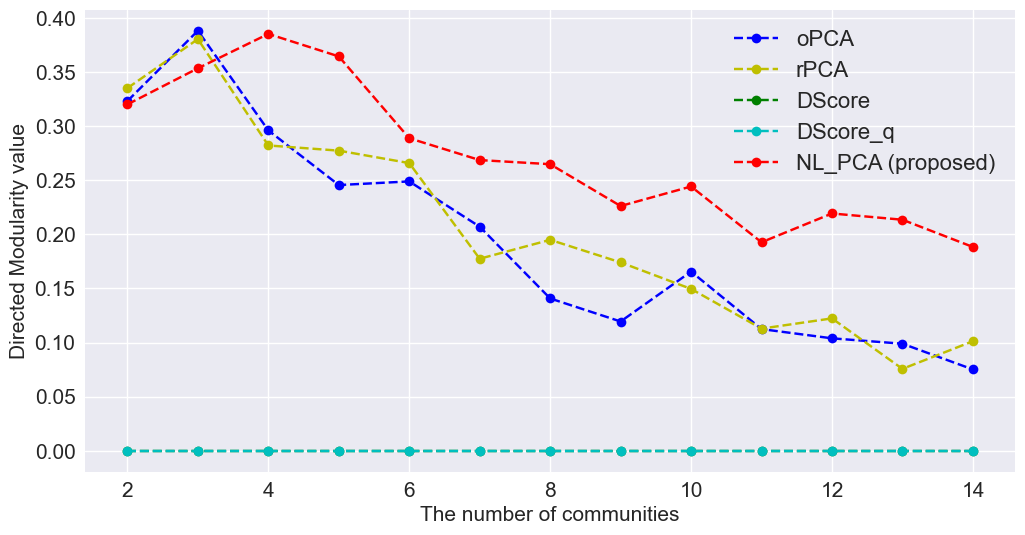

G = ( 1005 , 25571 )
graph is not strongly connected
------------------
K: 2
modularity - oPCA 0.11730947639967126
modularity - rPCA 0.088926659418616
modularity - dscore 0.0
modularity - dscore_q 0.0
modularity - NL_PCA 0.005089386659450874
K: 3
modularity - oPCA 0.19519841376173008
modularity - rPCA 0.21871235070991077
modularity - dscore 0.0
modularity - dscore_q 0.0
modularity - NL_PCA 0.007582128246231308
K: 4
modularity - oPCA 0.25805092772928195
modularity - rPCA 0.2859987769455526
modularity - dscore 0.0
modularity - dscore_q 0.0
modularity - NL_PCA 0.2462001020159722
K: 5
modularity - oPCA 0.316369186250701
modularity - rPCA 0.3249763176442796
modularity - dscore 0.0
modularity - dscore_q 0.0
modularity - NL_PCA 0.27910361682758156
K: 6
modularity - oPCA 0.33534749440375966
modularity - rPCA 0.36125707808278595
modularity - dscore 0.0
modularity - dscore_q 0.0
modularity - NL_PCA 0.33008227013474567
K: 7
modularity - oPCA 0.2937328774216396
modularity - rPCA 0.3749681126487397

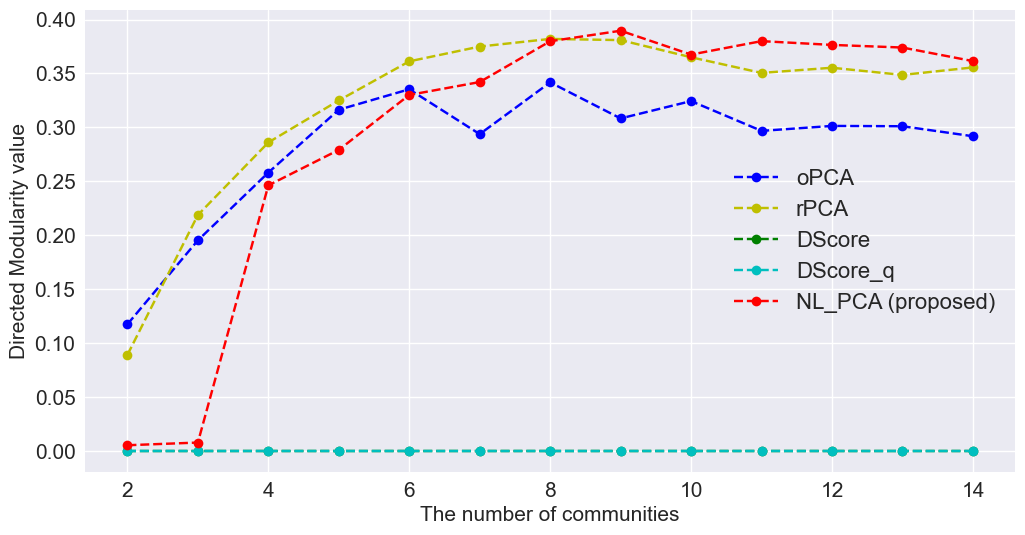

G = ( 332 , 2126 )
graph is not strongly connected
------------------
K: 2
modularity - oPCA 0.07482063667233345
modularity - rPCA 0.07696936818620678
modularity - dscore 0.0
modularity - dscore_q 0.0
modularity - NL_PCA 0.1050338549110639
K: 3
modularity - oPCA 0.18792174829574965
modularity - rPCA 0.20591737472443933
modularity - dscore 0.0
modularity - dscore_q 0.0
modularity - NL_PCA 0.24660875652340902
K: 4
modularity - oPCA 0.11288871641611406
modularity - rPCA 0.186026121070578
modularity - dscore 0.0
modularity - dscore_q 0.0
modularity - NL_PCA 0.273676091998984
K: 5
modularity - oPCA 0.07353099952299574
modularity - rPCA 0.2066118628033158
modularity - dscore 0.0
modularity - dscore_q 0.0
modularity - NL_PCA 0.28202919726116377
K: 6
modularity - oPCA 0.11453079686256878
modularity - rPCA 0.16652093995498993
modularity - dscore 0.0
modularity - dscore_q 0.0
modularity - NL_PCA 0.27571530723409227
K: 7
modularity - oPCA 0.11976611747755914
modularity - rPCA 0.1792604487379742
m

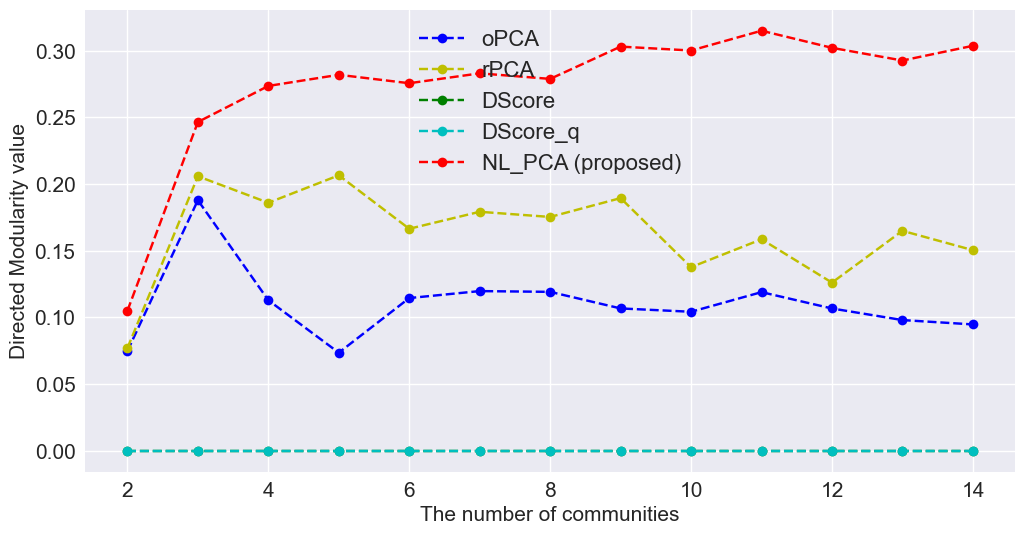

G = ( 1882 , 1740 )
graph is not strongly connected
------------------
K: 2
modularity - oPCA 0.07342713700620948
modularity - rPCA 0.07414519751618442
modularity - dscore 0.0
modularity - dscore_q 0.0
modularity - NL_PCA 0.037924428590302484
K: 3
modularity - oPCA 0.06298454221165273
modularity - rPCA 0.07275399656493593
modularity - dscore 0.0
modularity - dscore_q 0.0
modularity - NL_PCA 0.04264764169639312
K: 4
modularity - oPCA 0.06430968423834062
modularity - rPCA 0.07321574844761516
modularity - dscore 0.0
modularity - dscore_q 0.0
modularity - NL_PCA 0.08816191042409827
K: 5
modularity - oPCA 0.0726010701545779
modularity - rPCA 0.08556084026952031
modularity - dscore 0.0
modularity - dscore_q 0.0
modularity - NL_PCA 0.18876073457524106
K: 6
modularity - oPCA 0.090438631259083
modularity - rPCA 0.09398269256176506
modularity - dscore 0.0
modularity - dscore_q 0.0
modularity - NL_PCA 0.21077817413132507
K: 7
modularity - oPCA 0.0897806843704583
modularity - rPCA 0.09825142026687

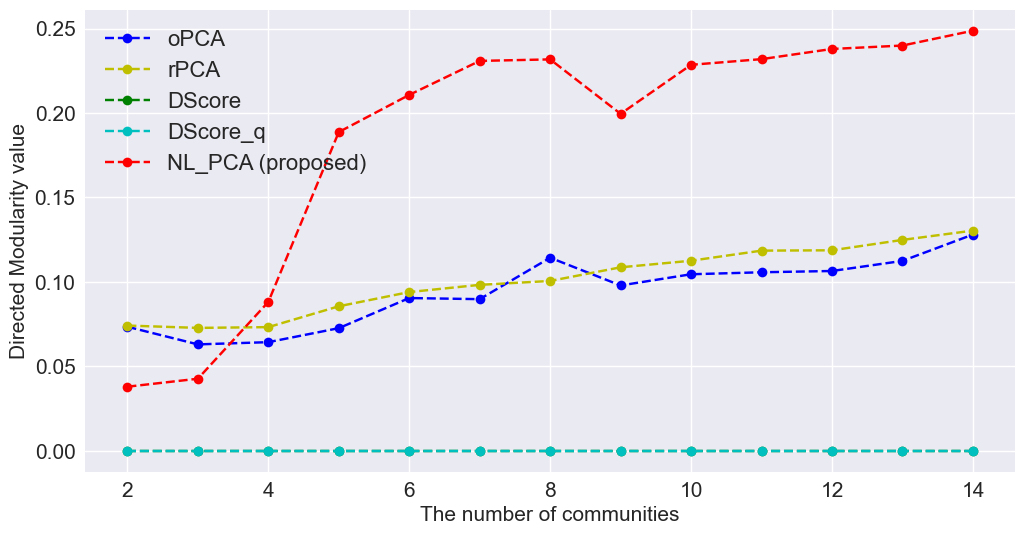

G = ( 1706 , 6207 )
graph is not strongly connected
------------------
K: 2
modularity - oPCA 0.20102687349282056
modularity - rPCA 0.21146722899658882
modularity - dscore 0.0
modularity - dscore_q 0.0
modularity - NL_PCA 0.08580919763253927
K: 3
modularity - oPCA 0.13299151456689334
modularity - rPCA 0.07694231625327053
modularity - dscore 0.0
modularity - dscore_q 0.0
modularity - NL_PCA 0.10906362988574542
K: 4
modularity - oPCA 0.07954203573720754
modularity - rPCA -0.016757119171619792
modularity - dscore 0.0
modularity - dscore_q 0.0
modularity - NL_PCA 0.16460313170173868
K: 5
modularity - oPCA 0.07229075494858145
modularity - rPCA -0.03165784463712567
modularity - dscore 0.0
modularity - dscore_q 0.0
modularity - NL_PCA 0.23230690368682894
K: 6
modularity - oPCA 0.0586335518900079
modularity - rPCA -0.042068766122036076
modularity - dscore 0.0
modularity - dscore_q 0.0
modularity - NL_PCA 0.26250135327703544
K: 7
modularity - oPCA 0.04782257173432481
modularity - rPCA 0.0258209

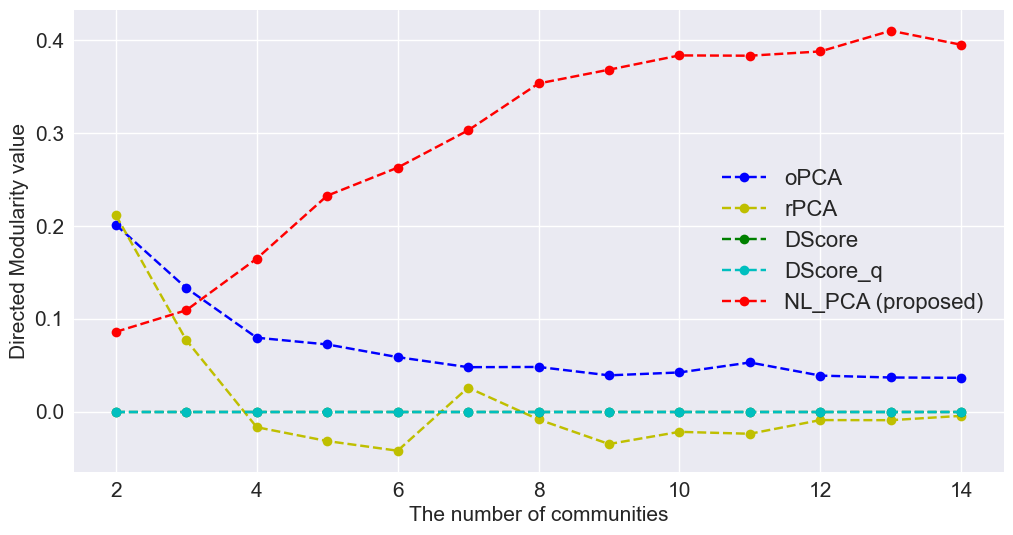

In [47]:
for index_dataset in range(len(lst_dataset_consider)):
  # Load graph data:
  link_data = link_source + lst_dataset_consider[index_dataset]
  with open(link_data) as file:
      lines = [line.rstrip() for line in file]
  if len(lines[0].split(' ')) >= 3:
    lines_new = [lines[i].split(' ')[0] +' ' +lines[i].split(' ')[1] for i in range(len(lines))]
    with open(link_data, 'w') as f:
      for line in lines_new:
          f.write(f"{line}\n")
  g = nx.read_adjlist(link_data, create_using=nx.DiGraph, nodetype = int)
  mapping = {list(g.nodes())[i]:i for i in range(len(list(g.nodes())))}
  g = nx.relabel_nodes(g, mapping)
  print("G = (",g.number_of_nodes(),",",g.number_of_edges(),")")

  if g.number_of_nodes() > 6000: # Test with graphs with number of vertices < 6000
    continue
  # The block below removes vertices that have only incoming edges and no outgoing edges:
  # temp = 1
  # while(temp):
  #   t = 0
  #   for i in range(g.number_of_nodes()):
  #     if g.out_degree(i) == 0:
  #       g.remove_node(i)
  #       # print("remove node:",i)
  #       t = t+1
  #   mapping = {list(g.nodes())[i]:i for i in range(len(list(g.nodes())))}
  #   g = nx.relabel_nodes(g, mapping)
  #   temp = 0
  #   for i in range(g.number_of_nodes()):
  #     if g.out_degree(i) == 0:
  #       temp = temp + 1

  # Create some variables to store graph information from the original graph, so that after running the algorithm, we can calculate modularity on the original graph.
  G1 = g.copy()
  G2 = g.copy()
  G_temp = checking_graph(G1)[1]
  number_loop = 1
  # Create dictionaries to store results for drawing shapes:
  dct_lst_oPCA = {}
  dct_lst_rPCA = {}
  dct_lst_DScore = {}
  dct_lst_DScore_q = {}
  dct_lst_hittingtingtimes_kmeans = {}
  dct_lst_L_oPCA = {}

  for i in range(1):
    dct_lst_oPCA[i] = []
    dct_lst_L_oPCA[i] = []
    dct_lst_rPCA[i] = []
    dct_lst_DScore[i] = []
    dct_lst_DScore_q[i] = []
    dct_lst_hittingtingtimes_kmeans[i] = []
    if g.number_of_nodes() > 900:
      limit = 15
    else:
      limit = 15

    adj_matrix = nx.to_numpy_array(g)
    U, s, Vh = LA.svd(adj_matrix)
    L_of_rPCA = preprocess_A_to_L(adj_matrix)
    U_L, s_L, Vh_L = LA.svd(L_of_rPCA)

    U_p,s_p,V_p = compute_input_for_Kmeans_proposed(G_temp)

    Adj_matrix_np = nx.to_numpy_array(G_temp)
    Dout_vector = np.sum(Adj_matrix_np,axis=1).reshape(Adj_matrix_np.shape[0]).tolist()
    Dout_matrix = np.diag(Dout_vector)
    Dout_inverse_matrix = np.diag([1/i for i in Dout_vector])
    P = np.dot(Dout_inverse_matrix,Adj_matrix_np)
    P = np.array(P)
    n = P.shape[0]
    pii = compute_stationary_distri_thHieu(P)
    sqrt_pii_vector = pii**(1/2)
    sqrt_pii_lst = sqrt_pii_vector.reshape(1,n).tolist()
    sqrtpi = np.diag(sqrt_pii_lst[0])
    Z_arr = Z_matrix(P,pii).reshape(n,n)
    data_z = [[Z_arr[i,j]/sqrt_pii_lst[0][j] for j in range(n)] for i in range(n)]
    for K in range(2,limit):
      print("K:",K)
      Class_Kmeans =  Original_KMeans(G_temp, K)
      bp = new_oPCA(U, s, Vh,K)
      bp_rcpa = new_rPCA(U_L, s_L, Vh_L,K)
      Q_oPCA = compute_modularity_general(bp,g)
      Q_rPCA = compute_modularity_general(bp_rcpa,g)
      print("modularity - oPCA", Q_oPCA)
      print("modularity - rPCA", Q_rPCA)
      bp_dscore = new_DScore(U, s, Vh,K)
      bp_dscoreq = new_DScore_q(U, s, Vh,K)
      Q_dscore = compute_modularity_general(bp_dscore,g)
      Q_dscore_q = compute_modularity_general(bp_dscoreq,g)
      print("modularity - dscore", Q_dscore)
      print("modularity - dscore_q", Q_dscore_q)

      bp_LoPCA = new_L_oPCA12(U_p,s_p,V_p,K)
      Q_LoPCA = compute_modularity_general(bp_LoPCA,g)
      print("modularity - NL_PCA", Q_LoPCA)

      # bp_hitting_times = Kmeans_hittingtimes(data_z,K)
      # Q_hittingtimes = compute_modularity_general(bp_hitting_times,g)
      # print("modularity - Hitting times", Q_hittingtimes)

      dct_lst_oPCA[i].append(Q_oPCA)
      dct_lst_rPCA[i].append(Q_rPCA)
      dct_lst_DScore[i].append(Q_dscore)
      dct_lst_DScore_q[i].append(Q_dscore_q)
      dct_lst_L_oPCA[i].append(Q_LoPCA)
      # dct_lst_hittingtingtimes_kmeans[i].append(Q_hittingtimes)
  for j in range(len(dct_lst_L_oPCA)):
    plt.figure(figsize=(12, 6))
    plt.style.use('seaborn-v0_8')
    number_loop = len(dct_lst_oPCA[j])
    plt.plot([i for i in range(2,limit)],dct_lst_oPCA[j],'bo--',label = 'oPCA')
    plt.plot([i for i in range(2,limit)],dct_lst_rPCA[j],'yo--',label = 'rPCA')
    plt.plot([i for i in range(2,limit)],dct_lst_DScore[j],'go--', label = 'DScore')
    plt.plot([i for i in range(2,limit)],dct_lst_DScore_q[j],'co--',label = 'DScore_q')
    plt.plot([i for i in range(2,limit)],dct_lst_L_oPCA[j],'ro--',label = 'NL_PCA (proposed)')
    plt.xlabel('The number of communities',fontsize=15)
    plt.ylabel('Directed Modularity value',fontsize=15)
    plt.yticks(fontsize=15 )
    plt.xticks(fontsize=15 )
    plt.legend(fontsize=16)
    plt.savefig('../images_results/result_'+str(lst_dataset_consider[index_dataset]) + '_NLPCA.png')
    plt.show()


### Hitting time WalkTrap compare Directed Louvain

In [48]:
lst_dataset_consider

['aves-songbird-social.txt',
 'stanford.txt',
 'inf-USAir97.txt',
 'ca-CSphd.txt',
 'Stelzl_data.txt']

In [49]:
dct_lst_directed_louvain = {}
dct_lst_hittingtimes_walktrap = {}
dct_lst_directed_louvain[0] = []
dct_lst_hittingtimes_walktrap[0] = []

In [55]:
lst_dataset_consider = ['data_set_innovation.txt','pol_blogs_handle.txt']

In [ ]:
for index_dataset in range(len(lst_dataset_consider)):
  link_data = link_source + lst_dataset_consider[index_dataset]
  with open(link_data) as file:
      lines = [line.rstrip() for line in file]
  start_idx = 0
  if len(lines[0].split(' ')) >= 3:
    if lst_dataset_consider[index_dataset] == 'email-dnc.txt':
      start_idx = 1
    lines_new = [lines[i].split(' ')[0][1:] +' ' +lines[i].split(' ')[1] for i in range(len(lines))]
    with open(link_data, 'w') as f:
      for line in lines_new:
          f.write(f"{line}\n")
  g = nx.read_adjlist(link_data, create_using=nx.DiGraph, nodetype = int)
  mapping = {list(g.nodes())[i]:i for i in range(len(list(g.nodes())))}
  g = nx.relabel_nodes(g, mapping)
  print("G = (",g.number_of_nodes(),",",g.number_of_edges(),")")
  G1 = g.copy()
  G2 = g.copy()
  G3 = g.copy()
  G_const = g.copy()
  # HITTING WALKTRAP:
  Q = {}
  data_test_record = []
  Q_proposed = {}
  lst_variance = []
  lst_silhouette = []
  partition = {}
  lst_each_variance = []
  variance = {}
  comm = {}
  community = {}
  C_Q, paritition,lst_variance, sqrtpi, pii, ps_inv_Laplacian = find_community_general(G3)
  Q_hitting_Walktrap = compute_modularity_general(C_Q,g)
  print("modularity - proposed walktrap hitting times:", Q_hitting_Walktrap)


  # DIRECTED LOUVAIN:
  dct_partition = {}
  P_init = singleton_partition(G_const)
  bp = directed_louvain_alg(G_const,P_init,0.0001)
  Q_directed_Louvain = compute_modularity_general(bp,g)
  print("modularity - directed louvain", Q_directed_Louvain)

  dct_lst_directed_louvain[0].append(Q_directed_Louvain) # each dictionary consists of (number_loop = 10) elements corresponding to 10 runs of a set of parameters
  dct_lst_hittingtimes_walktrap[0].append(Q_hitting_Walktrap)

G = ( 241 , 1098 )
graph is not strongly connected
------------------
SHAPE OF PII: (241,)
laplacian : (241, 241)
Step: 1
Step: 2
Step: 3
Step: 4
Step: 5
Step: 6
Step: 7
Step: 8
Step: 9
Step: 10
Step: 11
Step: 12
Step: 13
Step: 14
Step: 15
Step: 16
Step: 17
Step: 18
Step: 19
Step: 20
Step: 21
Step: 22
Step: 23
Step: 24
Step: 25
Step: 26
Step: 27
Step: 28
Step: 29
Step: 30
Step: 31
Step: 32
Step: 33
Step: 34
Step: 35
Step: 36
Step: 37
Step: 38
Step: 39
Step: 40
Step: 41
Step: 42
Step: 43
Step: 44
Step: 45
Step: 46
Step: 47
Step: 48
Step: 49
Step: 50
Step: 51
Step: 52
Step: 53
Step: 54
Step: 55
Step: 56
Step: 57
Step: 58
Step: 59
Step: 60
Step: 61
Step: 62
Step: 63
Step: 64
Step: 65
Step: 66
Step: 67
Step: 68
Step: 69
Step: 70
Step: 71
Step: 72
Step: 73
Step: 74
Step: 75
Step: 76
Step: 77
Step: 78
Step: 79
Step: 80
Step: 81
Step: 82
Step: 83
Step: 84
Step: 85
Step: 86
Step: 87
Step: 88
Step: 89
Step: 90
Step: 91
Step: 92
Step: 93
Step: 94
Step: 95
Step: 96
Step: 97
Step: 98
Step: 99
Step

# Experiments - benchmark


Adjust the parameters here: The number of parameter sets is also adjusted here, which is the number of values ​​in the `lst_number_nodes` or `lst_mean_cluster_size`

In [ ]:
lst_number_nodes = [10*i for i in range(20,24)]
lst_mean_cluster_size = [int(i/5) for i in lst_number_nodes]
lst_p_in = [0.5 for i in lst_number_nodes]
lst_p_out = [0.01 for i in lst_number_nodes]

In [ ]:
lst_number_comm = [i for i in range(3,7)]
lst_size_comm = [15 for _ in lst_number_comm]
lst_p_in = [0.5 for _ in lst_number_comm]
lst_p_out = [0.01 for _ in lst_number_comm]

In [ ]:
lst_set_algorithms = ['oPCA', 'rPCA', 'Hitting times Kmeans', 'DScore','DScoreq']
dct_color = {'oPCA':'bo--','rPCA':'yP--','Hitting times Kmeans':'rs-','DScore':'gv--','DScoreq':'c*--','LoPCA':'rs-'}

## Hitting time WalkTrap compares Directed Louvain

In [ ]:
number_loop = 10

dct_lst_directed_louvain = {}
dct_lst_hittingtimes_walktrap = {}
dct_lst_label = {}
dct_lst_oPCA = {}
dct_lst_rPCA = {}
dct_lst_DScore = {}
dct_lst_DScore_q = {}
dct_lst_hittingtingtimes_kmeans = {}
dct_lst_L_oPCA = {}

for i in range(len(lst_number_nodes)):
  # i ứng với bộ tham số thứ i
  dct_lst_directed_louvain[i] = [] # mỗi dictionary gồm (number_loop = 10) phần tử ứng với 10 lần chạy 1 bộ tham số
  dct_lst_hittingtimes_walktrap[i] = []
  dct_lst_label[i] = []
  dct_lst_oPCA[i] = []
  dct_lst_L_oPCA[i] = []
  dct_lst_rPCA[i] = []
  dct_lst_DScore[i] = []
  dct_lst_DScore_q[i] = []
  dct_lst_hittingtingtimes_kmeans[i] = []
  for loop in range(number_loop):
    number_nodes = lst_number_nodes[i]
    mean_cluster_size = lst_mean_cluster_size[i]
    variance_cluster_size = number_nodes/mean_cluster_size
    number_comm = lst_number_comm[i]
    number_size = lst_size_comm[i]
    p_in = lst_p_in[i]
    p_out = lst_p_out[i]
    g = generate_rand_graph_gaussian(number_nodes,mean_cluster_size,variance_cluster_size,p_in,p_out)
    # g = generate_rand_graph_partition_l(number_comm,number_size, p_in, p_out)
    lst_label_partition = g.graph['partition']

    G1 = g.copy()
    G2 = g.copy()
    G3 = g.copy()
    G_temp = checking_graph(G1)[1]
    G_const = g.copy()
    K = len(lst_label_partition)
    Q = {}
    data_test_record = []
    Q_proposed = {}
    lst_variance = []
    lst_silhouette = []
    partition = {}
    lst_each_variance = []
    variance = {}
    comm = {}
    community = {}
    C_Q, paritition,lst_variance, sqrtpi, pii, ps_inv_Laplacian = find_community_general(G3)
    print("modularity - proposed walktrap hitting times:", compute_modularity_general(C_Q,g))
    dct_partition = {}
    P_init = singleton_partition(G_const)
    bp = directed_louvain_alg(G_const,P_init,0.0001)
    print("modularity - directed louvain", compute_modularity_general(bp,g))
    dct_lst_directed_louvain[i].append(compute_modularity_general(bp,g)) # each dictionary consists of (number_loop = 10) elements corresponding to 10 runs of a set of parameters
    dct_lst_hittingtimes_walktrap[i].append(compute_modularity_general(C_Q,g))
    dct_lst_label[i].append(compute_modularity_general(lst_label_partition,g))

In [ ]:
for j in range(len(dct_lst_L_oPCA)):
  plt.figure(figsize=(12, 6))
  # plt.style.use('seaborn')
  plt.style.use('seaborn-whitegrid')
  number_loop = len(dct_lst_oPCA[j])
  plt.plot([i for i in range(len(dct_lst_label[j]))],dct_lst_label[j],dct_color['oPCA'],label = 'Label')
  plt.plot([i for i in range(len(dct_lst_label[j]))],dct_lst_hittingtimes_walktrap[j],dct_color['LoPCA'],label = 'Hittingtimes WalkTrap')
  plt.plot([i for i in range(len(dct_lst_label[j]))],dct_lst_directed_louvain[j],dct_color['DScore'], label = 'Directed Louvain')
  # plt.plot([i for i in range(len(dct_lst_D[j]))],dct_lst_DScore_q[j],dct_color['DScoreq'],label = 'DScore_q')
  plt.xlabel('The order of experiments',fontsize=15)
  plt.ylabel('Directed Modularity value ($Q_d$)',fontsize=15)
  plt.yticks(fontsize=15 )
  # plt.xticks(fontsize=15 )
  plt.xticks([i for i in range(0,8+2)],fontsize=15 )
  # plt.title('Parameter '+str(j),fontsize=20)
  # plt_title('')
  plt.legend(fontsize=16)
  plt.savefig('../images_results/hitting_walktrap_gaussian_medium'+str(j) + '_based_Kmeans.png')
  plt.show()

## Laplacian PCA compares oPCA, rPCA, Dscore

In [ ]:
number_loop = 10

dct_lst_directed_louvain = {}
dct_lst_hittingtimes_walktrap = {}
dct_lst_label = {}
dct_lst_oPCA = {}
dct_lst_rPCA = {}
dct_lst_DScore = {}
dct_lst_DScore_q = {}
dct_lst_rDScore = {}
dct_lst_rDScore_q = {}
dct_lst_r_impro_DScore = {}
dct_lst_r_impro_DScore_q = {}
dct_lst_hittingtingtimes_kmeans = {}
dct_lst_L_oPCA = {}

for i in range(len(lst_number_nodes)):
  # i ứng với bộ tham số thứ i
  dct_lst_directed_louvain[i] = [] # mỗi dictionary gồm (number_loop = 10) phần tử ứng với 10 lần chạy 1 bộ tham số
  dct_lst_hittingtimes_walktrap[i] = []
  dct_lst_label[i] = []
  dct_lst_oPCA[i] = []
  dct_lst_L_oPCA[i] = []
  dct_lst_rPCA[i] = []
  dct_lst_DScore[i] = []
  dct_lst_DScore_q[i] = []
  dct_lst_hittingtingtimes_kmeans[i] = []
  for loop in range(number_loop):
    number_nodes = lst_number_nodes[i]
    mean_cluster_size = lst_mean_cluster_size[i]
    variance_cluster_size = number_nodes/mean_cluster_size
    number_comm = lst_number_comm[i]
    number_size = lst_size_comm[i]
    p_in = lst_p_in[i]
    p_out = lst_p_out[i]
    # g = generate_rand_graph_gaussian(number_nodes,mean_cluster_size,variance_cluster_size,p_in,p_out)
    g = generate_rand_graph_partition_l(number_comm,number_size, p_in, p_out)
    lst_label_partition = g.graph['partition']
    # tao cac do thi copy tu  de tranh thay doi trong g khi tinh modularity:
    G1 = g.copy()
    G2 = g.copy()
    G3 = g.copy()
    G_temp = checking_graph(G1)[1]
    G_const = g.copy()
    K = len(lst_label_partition)
    adj_matrix = nx.to_numpy_array(G_const)
    if 1:
      # print("K:",K)
      # K = 3
      adj_matrix = nx.to_numpy_array(g)
      U, s, Vh = LA.svd(adj_matrix)
      L_of_rPCA = preprocess_A_to_L(adj_matrix)
      U_L, s_L, Vh_L = LA.svd(L_of_rPCA)

      U_p,s_p,V_p = compute_input_for_Kmeans_proposed(G_temp)

      Adj_matrix_np = nx.to_numpy_array(G_temp)
      Dout_vector = np.sum(Adj_matrix_np,axis=1).reshape(Adj_matrix_np.shape[0]).tolist()
      Dout_matrix = np.diag(Dout_vector)
      Dout_inverse_matrix = np.diag([1/i for i in Dout_vector])
      P = np.dot(Dout_inverse_matrix,Adj_matrix_np)
      P = np.array(P)
      n = P.shape[0]
      pii = compute_stationary_distri_thHieu(P)
      sqrt_pii_vector = pii**(1/2)
      sqrt_pii_lst = sqrt_pii_vector.reshape(1,n).tolist()
      sqrtpi = np.diag(sqrt_pii_lst[0])
      Z_arr = Z_matrix(P,pii).reshape(n,n)
      data_z = [[Z_arr[i,j]/sqrt_pii_lst[0][j] for j in range(n)] for i in range(n)]

      Class_Kmeans =  Original_KMeans(G2, K)
      # Class_Kmeans =  Original_KMeans(G_temp, K)
      # K = 3

      bp = new_oPCA(U, s, Vh,K)
      bp_rcpa = new_rPCA(U_L, s_L, Vh_L,K)
      Q_oPCA = compute_modularity_general(bp,g)
      Q_rPCA = compute_modularity_general(bp_rcpa,g)
      print("modularity - oPCA", Q_oPCA)
      print("modularity - rPCA", Q_rPCA)
      bp_dscore = new_DScore(U, s, Vh,K)
      bp_dscoreq = new_DScore_q(U, s, Vh,K)
      Q_dscore = compute_modularity_general(bp_dscore,g)
      Q_dscore_q = compute_modularity_general(bp_dscoreq,g)
      print("modularity - dscore", Q_dscore)
      print("modularity - dscore_q", Q_dscore_q)
      # bp_LoPCA = new_L_oPCA12(U_p,s_p,V_p,K)
      # Q_LoPCA = compute_modularity_general(bp_LoPCA,g)
      # print("modularity - L_oPCA", Q_LoPCA)
      bp_hitting_times = Kmeans_hittingtimes(data_z,K)
      Q_hittingtimes = compute_modularity_general(bp_hitting_times,g)
      print("modularity - Hitting times", Q_hittingtimes)

      dct_lst_oPCA[i].append(Q_oPCA)
      dct_lst_rPCA[i].append(Q_rPCA)
      dct_lst_DScore[i].append(Q_dscore)
      dct_lst_DScore_q[i].append(Q_dscore_q)
      # dct_lst_L_oPCA[i].append(Q_LoPCA)
      dct_lst_hittingtingtimes_kmeans[i].append(Q_hittingtimes)

In [ ]:
for j in range(len(dct_lst_L_oPCA)):
  plt.figure(figsize=(12, 6))
  # plt.style.use('seaborn')
  plt.style.use('seaborn-whitegrid')
  number_loop = len(dct_lst_oPCA[j])
  plt.plot([i for i in range(len(dct_lst_oPCA[j]))],dct_lst_oPCA[j],dct_color['oPCA'],label = 'oPCA')
  plt.plot([i for i in range(len(dct_lst_oPCA[j]))],dct_lst_rPCA[j],dct_color['rPCA'],label = 'rPCA')
  plt.plot([i for i in range(len(dct_lst_DScore[j]))],dct_lst_DScore[j],dct_color['DScore'], label = 'DScore')
  plt.plot([i for i in range(len(dct_lst_DScore[j]))],dct_lst_DScore_q[j],dct_color['DScoreq'],label = 'DScore_q')
  plt.plot([i for i in range(number_loop)],dct_lst_r_impro_DScore_q[j],'wo--',label = 'R-Improve-DScore_q')
  plt.plot([i for i in range(len(dct_lst_DScore[j]))],dct_lst_hittingtingtimes_kmeans[j],dct_color['Hitting times Kmeans'], label = 'Hitting times Kmeans')
  plt.xlabel('The order of experiments',fontsize=15)
  plt.ylabel('Directed Modularity value ($Q_d$)',fontsize=15)
  plt.yticks(fontsize=15 )
  # plt.xticks(fontsize=15 )
  plt.xticks([i for i in range(0,8+2)],fontsize=15 )
  # plt.title('Parameter '+str(j),fontsize=20)
  # plt_title('')
  plt.legend(fontsize=16)
  plt.savefig('../images_results/'+str(j) + '_based_Kmeans.png')
  plt.show()